# Comparing the NN Models trained via Different Validation Schemes
The goal is to see how the model weights/properties differ under different schemes. See if there is a way to manually for the models to be similar. Is there a fundemental difference between these models or are they more subtle. We know for one thing that random split trains a model with low error. But the same architecture seems to fail for hold-one out. How do we put them together?

In [2]:
from inverse_modelling_tfo.model_training.custom_models import PerceptronBD
from sklearn.preprocessing import StandardScaler
import joblib
import torch

# Load Pre-Trained Model

In [4]:
model_random_split_name = 'multi_output_random_split'
model_holdoneout_split_name = 'multi_output_holdoneout_split'
model_rs = PerceptronBD([40, 40, 20, 6])
model_hs = PerceptronBD([40, 40, 20, 6])
model_rs.load_state_dict(torch.load(fr'../../models/{model_random_split_name}'))
model_hs.load_state_dict(torch.load(fr'../../models/{model_holdoneout_split_name}'))
model_hs = model_hs.cuda()
model_rs = model_rs.cuda()
x_scaler = joblib.load(fr'../../models/{model_random_split_name}_xscaler')
y_scaler = joblib.load(fr'../../models/{model_random_split_name}_yscaler')

# Visualize Weights

Text(0.5, 0.98, 'Hold-one-out split model weights')

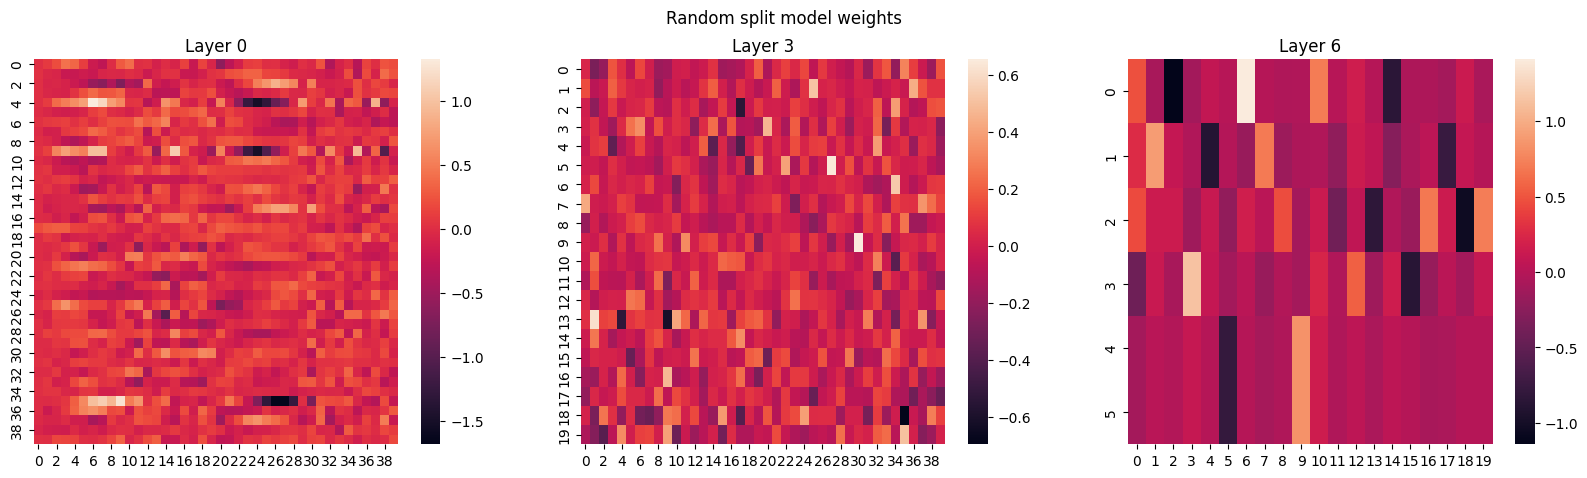

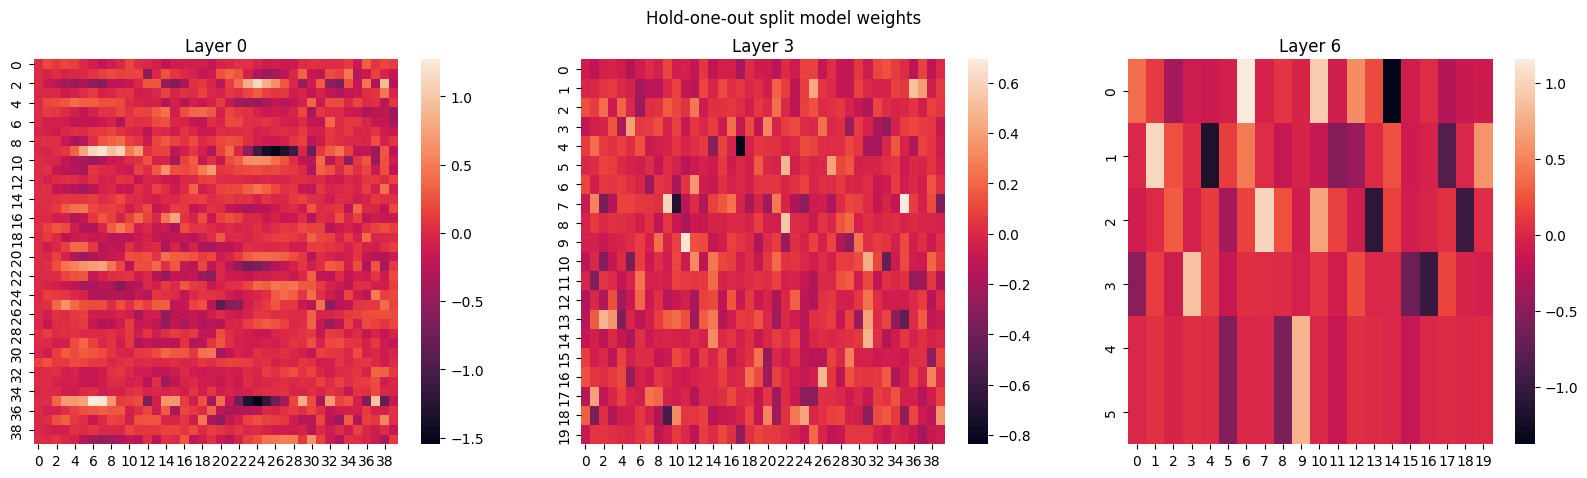

In [10]:
# For both model_hs and model_rs, visualize the weights in each layer as a heatmap
from typing import List
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

def plot_weights(model: torch.nn.Module, layers_to_plot: List[int]) -> Figure:
    fig, axes = plt.subplots(1, len(layers_to_plot), figsize=(20, 5))
    for i, layer in enumerate(layers_to_plot):
        weights = model.layers[layer].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=axes[i])
        axes[i].set_title(f'Layer {layer}')
    return fig

fig1 = plot_weights(model_rs, [0, 3, 6])
fig1.suptitle('Random split model weights')
fig2 = plot_weights(model_hs, [0, 3, 6])
fig2.suptitle('Hold-one-out split model weights')

Text(0.5, 0.98, 'Hold-one-out split model biases')

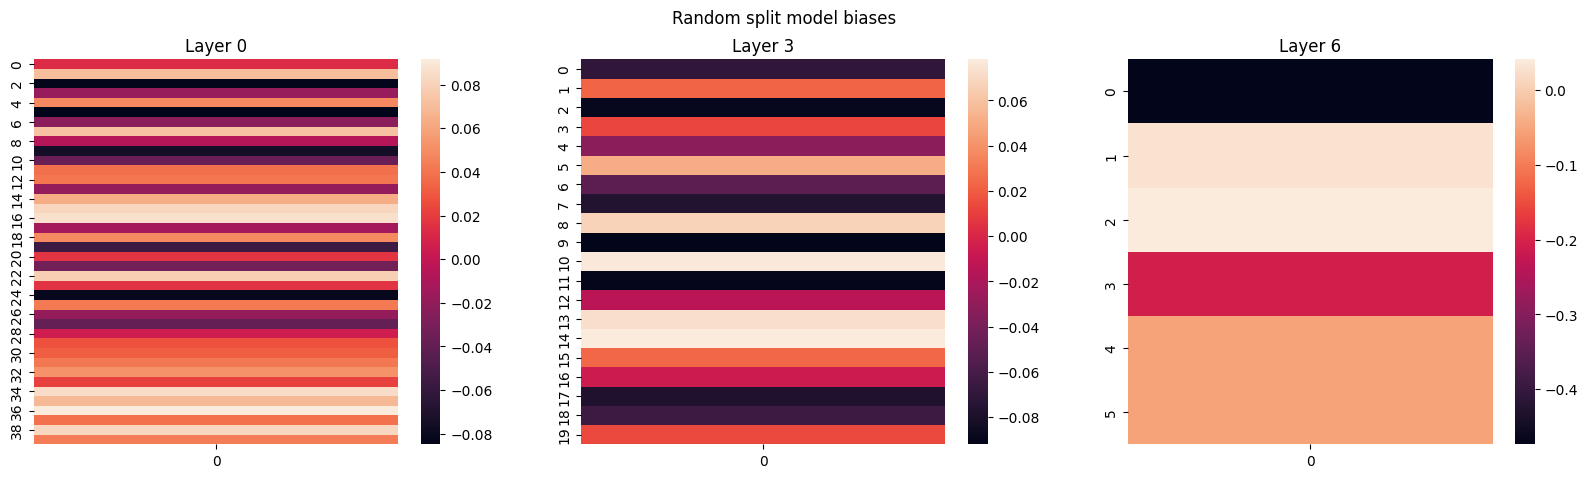

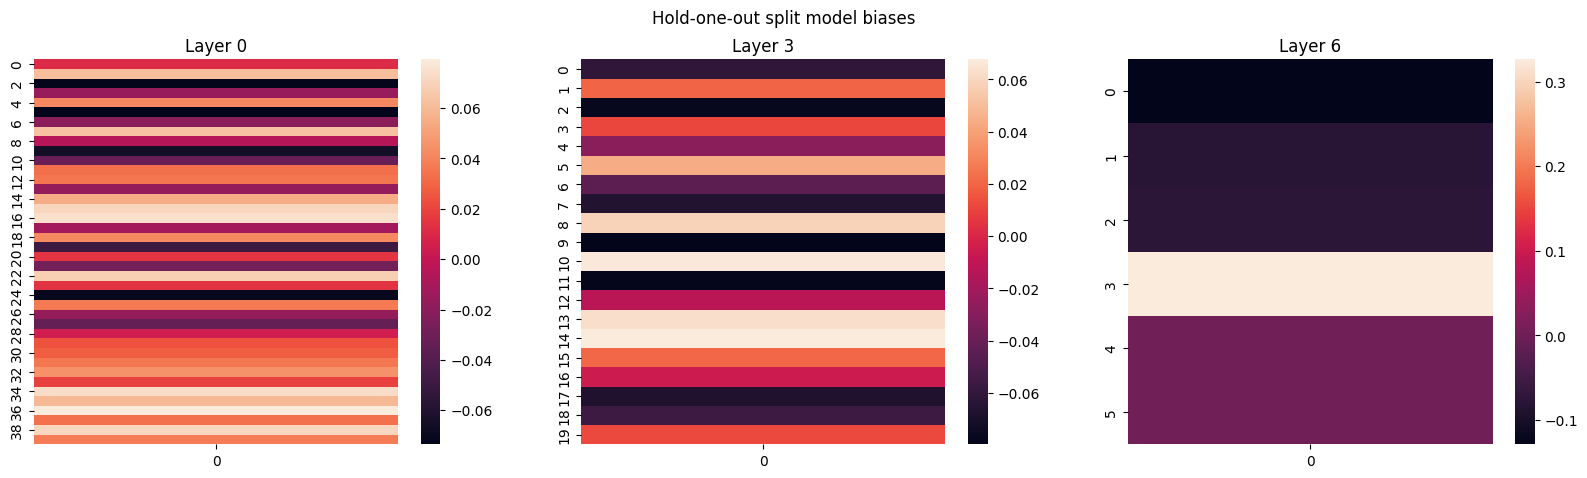

In [11]:
# DO the same thing but with Biases
def plot_biases(model: torch.nn.Module, layers_to_plot: List[int]) -> Figure:
    fig, axes = plt.subplots(1, len(layers_to_plot), figsize=(20, 5))
    for i, layer in enumerate(layers_to_plot):
        biases = model.layers[layer].bias.detach().cpu().numpy()
        sns.heatmap(biases.reshape(-1, 1), ax=axes[i])
        axes[i].set_title(f'Layer {layer}')
    return fig

fig3 = plot_biases(model_rs, [0, 3, 6])
fig3.suptitle('Random split model biases')
fig4 = plot_biases(model_hs, [0, 3, 6])
fig4.suptitle('Hold-one-out split model biases')

# Compare Model Performance

In [14]:
# Load & Scale the data
from pathlib import Path
import json
import pandas as pd

file_name = 'pulsation_ratio'
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Cleanup
data.dropna(inplace=True)
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 12.0)
    # & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]

y_columns = labels  # What to Predict
if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print("Y Columns", y_columns)

x_columns = features  # What to use as input
print("X Columns", x_columns)

x_data = x_scaler.transform(data[x_columns])
y_data = y_scaler.transform(data[y_columns])

Y Columns ['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'Fetal Hb Concentration 1', 'Fetal Hb Concentration 2']
X Columns ['MAX_ACbyDC_WV1_10', 'MAX_ACbyDC_WV1_15', 'MAX_ACbyDC_WV1_19', 'MAX_ACbyDC_WV1_24', 'MAX_ACbyDC_WV1_28', 'MAX_ACbyDC_WV1_33', 'MAX_ACbyDC_WV1_37', 'MAX_ACbyDC_WV1_41', 'MAX_ACbyDC_WV1_46', 'MAX_ACbyDC_WV1_50', 'MAX_ACbyDC_WV1_55', 'MAX_ACbyDC_WV1_59', 'MAX_ACbyDC_WV1_64', 'MAX_ACbyDC_WV1_68', 'MAX_ACbyDC_WV1_72', 'MAX_ACbyDC_WV1_77', 'MAX_ACbyDC_WV1_81', 'MAX_ACbyDC_WV1_86', 'MAX_ACbyDC_WV1_90', 'MAX_ACbyDC_WV1_94', 'MAX_ACbyDC_WV2_10', 'MAX_ACbyDC_WV2_15', 'MAX_ACbyDC_WV2_19', 'MAX_ACbyDC_WV2_24', 'MAX_ACbyDC_WV2_28', 'MAX_ACbyDC_WV2_33', 'MAX_ACbyDC_WV2_37', 'MAX_ACbyDC_WV2_41', 'MAX_ACbyDC_WV2_46', 'MAX_ACbyDC_WV2_50', 'MAX_ACbyDC_WV2_55', 'MAX_ACbyDC_WV2_59', 'MAX_ACbyDC_WV2_64', 'MAX_ACbyDC_WV2_68', 'MAX_ACbyDC_WV2_72', 'MAX_ACbyDC_WV2_77', 'MAX_ACbyDC_WV2_81', 'MAX_ACbyDC_WV2_86', 'MAX_ACbyDC_WV2_90', 'MAX

In [45]:
# Evaluate both models
model_rs.eval()
model_hs.eval()

x_data_tensor = torch.tensor(x_data, dtype=torch.float32).cuda()
y_data_tensor = torch.tensor(y_data, dtype=torch.float32).cuda()
criterion = torch.nn.MSELoss()
y_pred_rs = model_rs(x_data_tensor)
y_pred_hs = model_hs(x_data_tensor)
loss_rs = criterion(y_pred_rs, y_data_tensor).item()
loss_hs = criterion(y_pred_hs, y_data_tensor).item()

print(f'Random split model MSE: {loss_rs}')
print(f'Hold-one-out split model MSE: {loss_hs}')

Random split model MSE: 0.032694458961486816
Hold-one-out split model MSE: 1.0573053359985352


In [48]:
model_rs.layers

[Linear(in_features=40, out_features=40, bias=True),
 BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=40, out_features=20, bias=True),
 BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 Linear(in_features=20, out_features=6, bias=True),
 Flatten(start_dim=1, end_dim=-1)]

In [56]:
# Create a Frankenstein model by grafting the last linear layer from rs onto hs
LAYER_TO_REPLACE  = 6
model_frankenstein = PerceptronBD([40, 40, 20, 6])
# Copy the layers on
model_frankenstein.layers[0] = model_hs.layers[0]
model_frankenstein.layers[1] = model_hs.layers[1]
model_frankenstein.layers[3] = model_hs.layers[3]
model_frankenstein.layers[4] = model_hs.layers[4]
model_frankenstein.layers[6] = model_rs.layers[6]
model_frankenstein.model = torch.nn.Sequential(*model_frankenstein.layers)  # Update the model

# model_frankenstein.layers[0] = model_hs.layers[0]
# model_frankenstein.layers[3] = model_hs.layers[3]
# # model_frankenstein.layers[6] = model_hs.layers[6]
# # model_frankenstein.layers[LAYER_TO_REPLACE] = model_rs.layers[LAYER_TO_REPLACE]
# model_frankenstein.model = torch.nn.Sequential(*model_frankenstein.layers)  # Update the model
model_frankenstein = model_frankenstein.cuda()
model_frankenstein.eval()
y_pred_frankenstein = model_frankenstein(x_data_tensor)
loss_frankenstein = criterion(y_pred_frankenstein, y_data_tensor).item()
print(f'Frankenstein model MSE: {loss_frankenstein}')

Frankenstein model MSE: 0.4180489778518677
